In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Change working directory

In [2]:
notebook_path = %pwd

os.chdir(Path(notebook_path).parent)
os.getcwd()

'/home/atleeri/repositories/forecast-electricity-markets'

Load processed data

In [4]:
processed_data_dir = Path('data/processed')
filepaths = list(processed_data_dir.glob('**/*60*.parquet'))
filepaths

[PosixPath('data/processed/opsd-time_series-2020-10-06/time_series_60min_singleindex.parquet')]

In [5]:
filepath = filepaths[0]
df = pd.read_parquet(filepath)
df

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
0,2014-12-31 23:00:00+00:00,2015-01-01 00:00:00+01:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+01:00,8852.0,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+01:00,9054.0,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+01:00,9070.0,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+01:00,9163.0,NaN
...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30 20:00:00+01:00,10654.0,49.92
50397,2020-09-30 20:00:00+00:00,2020-09-30 21:00:00+01:00,11836.0,42.79
50398,2020-09-30 21:00:00+00:00,2020-09-30 22:00:00+01:00,12168.0,35.02
50399,2020-09-30 22:00:00+00:00,2020-09-30 23:00:00+01:00,12533.0,34.40


In [6]:
df.columns

Index(['utc_timestamp', 'cet_cest_timestamp', 'DE_wind_generation',
       'DE_price_ahead'],
      dtype='object')

In [9]:
df_sample = df.sample(n=len(df), random_state=2025)

In [10]:
df_sample

,utc_timestamp,cet_cest_timestamp,DE_wind_generation,DE_price_ahead
20095,2017-04-17 06:00:00+00:00,2017-04-17 07:00:00+01:00,6150.0,NaN
47699,2020-06-10 10:00:00+00:00,2020-06-10 11:00:00+01:00,3769.0,34.90
48713,2020-07-22 16:00:00+00:00,2020-07-22 17:00:00+01:00,3007.0,42.19
46775,2020-05-02 22:00:00+00:00,2020-05-02 23:00:00+01:00,12000.0,18.00
18157,2017-01-26 12:00:00+00:00,2017-01-26 13:00:00+01:00,9436.0,NaN
...,...,...,...,...
15948,2016-10-26 11:00:00+00:00,2016-10-26 12:00:00+01:00,1797.0,NaN
11102,2016-04-07 13:00:00+00:00,2016-04-07 14:00:00+01:00,17177.0,NaN
16338,2016-11-11 17:00:00+00:00,2016-11-11 18:00:00+01:00,3593.0,NaN
32478,2018-09-15 05:00:00+00:00,2018-09-15 06:00:00+01:00,13707.0,NaN


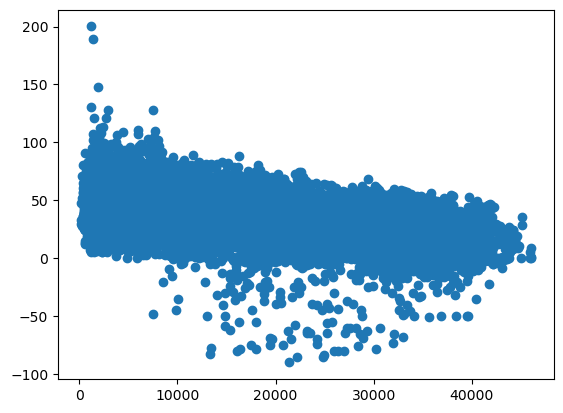

In [11]:
valid_mask = df_sample['DE_wind_generation'].notna() & df_sample['DE_price_ahead'].notna()
plt.scatter(df_sample[valid_mask]['DE_wind_generation'], df_sample[valid_mask]['DE_price_ahead'])

Linear regression

In [13]:
rng = np.random.default_rng()
X = df_sample[valid_mask]['DE_wind_generation']
y = df_sample[valid_mask]['DE_price_ahead']

reg = stats.linregress(X, y)
reg

LinregressResult(slope=np.float64(-0.0006888959392140088), intercept=np.float64(45.70993079848809), rvalue=np.float64(-0.3917992514347587), pvalue=np.float64(0.0), stderr=np.float64(1.221551452471734e-05), intercept_stderr=np.float64(0.21609572632577723))

Torch

In [45]:
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1)
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
model = SimpleNeuralNet()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

Check whether you need to normalize, then train.

In [47]:
x_in = torch.tensor(X.values.reshape(len(X), 1), dtype = torch.float32)
y_tensor = torch.tensor(y.values.reshape(len(y), 1), dtype=torch.float32)
y_tensor.shape

torch.Size([17540, 1])

In [62]:
nepochs = 2000

losses = []
for epoch in range(nepochs):
    optimizer.zero_grad()

    y_out = model(x_in)

    loss = criterion(y_out, y_tensor)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())



In [63]:
losses

[412.7330627441406,
 412.5249328613281,
 412.3168640136719,
 412.10894775390625,
 411.9011535644531,
 411.6934509277344,
 411.4858703613281,
 411.2783203125,
 411.0708923339844,
 410.86358642578125,
 410.6563720703125,
 410.44921875,
 410.2422790527344,
 410.03533935546875,
 409.8284912109375,
 409.6218566894531,
 409.4152526855469,
 409.2087097167969,
 409.00238037109375,
 408.7960510253906,
 408.5898132324219,
 408.3837585449219,
 408.1777648925781,
 407.9718933105469,
 407.7661437988281,
 407.5604248046875,
 407.3548889160156,
 407.1493835449219,
 406.9440002441406,
 406.73876953125,
 406.5335998535156,
 406.3285217285156,
 406.12353515625,
 405.91876220703125,
 405.71392822265625,
 405.5093078613281,
 405.3047790527344,
 405.100341796875,
 404.89599609375,
 404.6917724609375,
 404.4876403808594,
 404.28363037109375,
 404.0796813964844,
 403.87591552734375,
 403.6721496582031,
 403.4686279296875,
 403.26507568359375,
 403.0616455078125,
 402.85833740234375,
 402.65521240234375,
 402

In [76]:
y_out.detach().numpy().flatten()

array([38.245132 , 38.90504  , 31.116856 , ...,  4.3887215, 34.35927  ,
       19.52507  ], shape=(17540,), dtype=float32)

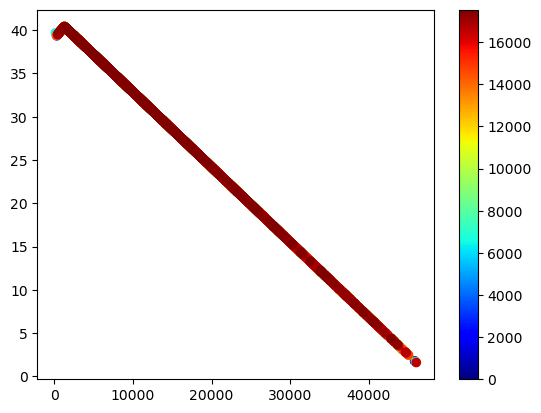

In [77]:
plt.scatter(x_in.flatten(), y_out.detach().numpy().flatten(), c = range(len(y_out)), cmap='jet')
plt.colorbar()


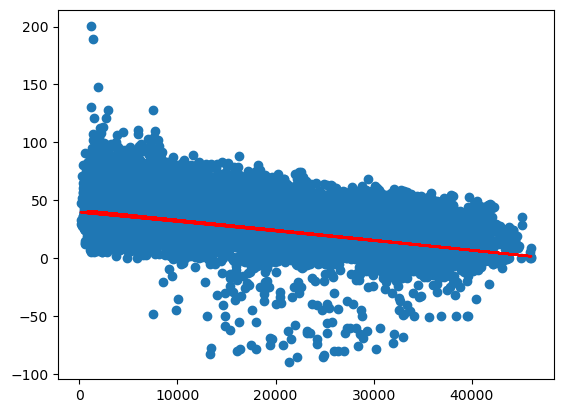

In [78]:
plt.scatter(x_in.flatten(), y)
plt.plot(x_in.flatten(), y_out.detach().numpy().flatten(), 'r')
#plt.plot(x_in.flatten(), reg[0]*x_in.flatten()+reg[1], 'orange')

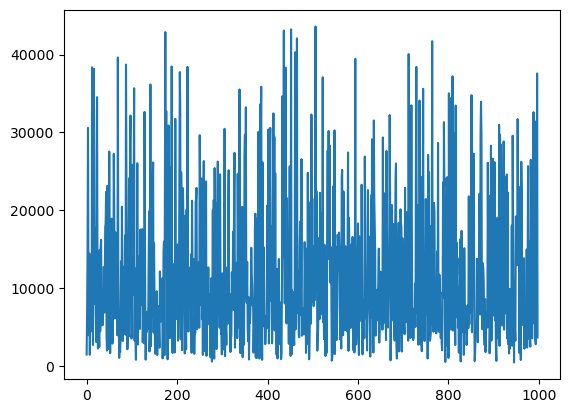

In [53]:
plt.plot(x_in)

In [20]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [22]:
EPOCHS = 5

features, target = make_regression(n_features=10, n_samples=1000)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1
)

In [28]:
features_train.shape

(900, 10)